In [1]:
!nvidia-smi

Thu Feb 16 22:53:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    24W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
! gdown --id 1vOCuRd_OaR-Uohu-hhHyvcXsOkX2__Pl      #   Install the test video

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1vOCuRd_OaR-Uohu-hhHyvcXsOkX2__Pl
To: /content/test.mp4
100% 22.2M/22.2M [00:00<00:00, 40.5MB/s]


In [4]:
! gdown --id 1mvuyb3ZsZ1AaaqYTw8K8U_BhY0kydYWL     #   Install the YOLO .pt file

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1mvuyb3ZsZ1AaaqYTw8K8U_BhY0kydYWL
To: /content/stromavision.pt
100% 22.5M/22.5M [00:02<00:00, 9.38MB/s]


In [5]:
SOURCE_VIDEO_PATH = f"{HOME}/test.mp4"

In [6]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.39 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.4/78.2 GB disk)


In [7]:
%cd {HOME} #   Install the ByteTrack for tracking
!git clone https://github.com/ifzhang/ByteTrack.git
!cd ByteTrack && pip3 install -q -r requirements.txt
!cd ByteTrack && python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [8]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.7
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [9]:
!pip install -i https://test.pypi.org/simple/ supervision   #   Install the supervision for Inference


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.2.1


In [13]:
%cd /usr/local/lib/python3.8/dist-packages/supervision

/usr/local/lib/python3.8/dist-packages/supervision


In [15]:
with open("__init__.py", "r") as file: #   Adding new line to init file which is forgotten by developer
    lines = file.readlines()

lines[1] = "\n" + str("from supervision.detection.line_counter import LineZone") + "\n"


with open("__init__.py", "w") as file:
    for line in lines:
        file.write(line)
file.close()

In [16]:
with open("__init__.py", "r") as file: #   Adding new line to init file which is forgotten by developer
    lines = file.readlines()

lines[1] = "\n" + str("from supervision.detection.line_counter import LineZoneAnnotator") + "\n"


with open("__init__.py", "w") as file:
    for line in lines:
        file.write(line)
file.close()

In [17]:
import importlib  #   Forcing library to reload. So codes can see at new operations
importlib.reload(supervision)

<module 'supervision' from '/usr/local/lib/python3.8/dist-packages/supervision/__init__.py'>

In [18]:
%cd /content

/content


In [19]:
importlib.reload(supervision)
from supervision import ColorPalette
from supervision import Point
from supervision import VideoInfo
from supervision import get_video_frames_generator
from supervision import VideoSink
from supervision import show_frame_in_notebook
from supervision import Detections, BoxAnnotator
from supervision import LineZone
from supervision import LineZoneAnnotator


In [20]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections, 
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)
    
    tracker_ids = [None] * len(detections)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [21]:
# settings
MODEL = "stromavision.pt"

In [22]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs


In [23]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [0, 1]


0: 640x640 39.4ms
Speed: 0.7ms pre-process, 39.4ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)


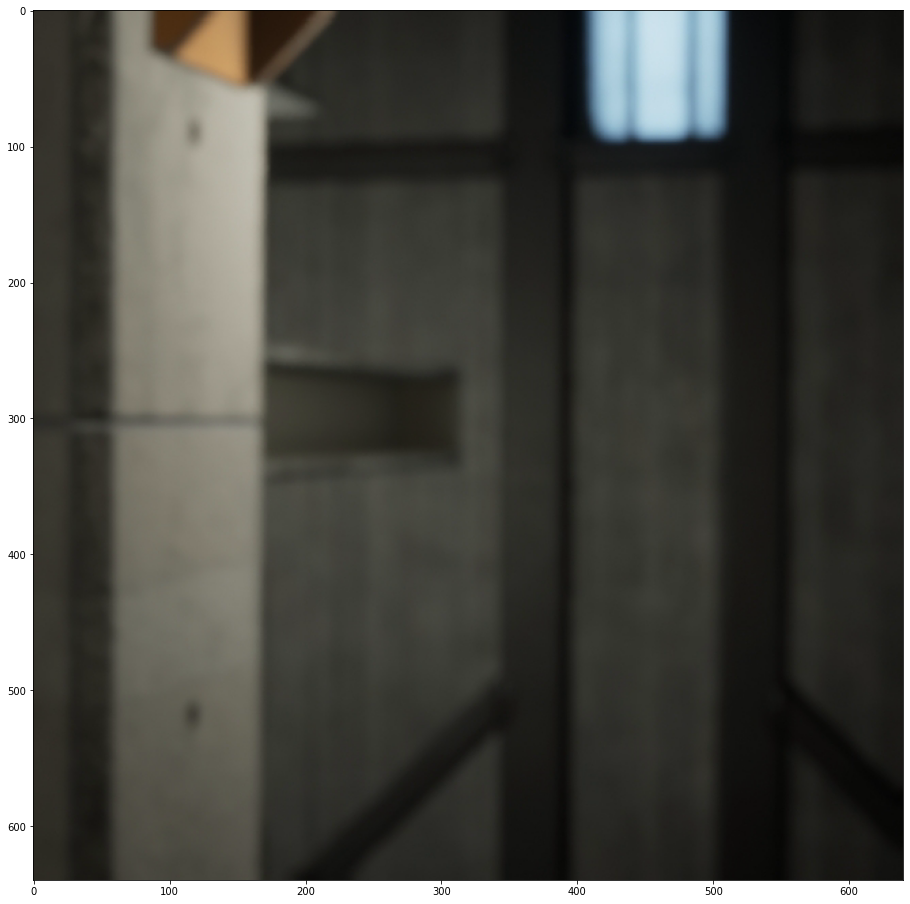

In [24]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(thickness=2, text_thickness=2, text_scale=1)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
show_frame_in_notebook(frame, (16, 16))

In [25]:
# settings
LINE_START = Point(50, 1500)
LINE_END = Point(3840-50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/output.mp4"



In [ ]:
from tqdm.notebook import tqdm


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineZone(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(thickness=2, text_thickness=2, text_scale=1)
line_annotator = LineZoneAnnotator(thickness=2, text_thickness=2, text_scale=1)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.trigger(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/1800 [00:00<?, ?it/s]


0: 640x640 40.6ms
Speed: 0.7ms pre-process, 40.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 37.9ms
Speed: 0.7ms pre-process, 37.9ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 34.2ms
Speed: 0.6ms pre-process, 34.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 19.6ms
Speed: 1.5ms pre-process, 19.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 21.3ms
Speed: 0.6ms pre-process, 21.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 17.4ms
Speed: 0.7ms pre-process, 17.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 17.2ms
Speed: 0.6ms pre-process, 17.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 17.3ms
Speed: 0.7ms pre-process, 17.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 21.8ms
Speed: 0.5ms pre-process, 21.8ms inference, 0